Pixel wise segmentation using RNN's

In [37]:
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
import numpy as np

from tensorflow.keras.metrics import MeanIoU

import os

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import glob
import PIL
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
np.random.seed(101)
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from keras.optimizers import Adam, SGD
import random
from tensorflow.keras.metrics import MeanIoU
import os
from tensorflow.keras.optimizers import Adam
from keras import backend, optimizers
from keras.layers import concatenate
from sklearn.metrics import roc_curve, auc
from PIL import Image
import re
from sklearn.metrics import ConfusionMatrixDisplay,f1_score
from sklearn.metrics import confusion_matrix

ModuleNotFoundError: No module named 'pandas'

In [3]:
 !git clone https://github.com/Shankar0x/Datasets.git imgs

Cloning into 'imgs'...
Updating files:   6% (672/9861)
Updating files:   7% (691/9861)
Updating files:   8% (789/9861)
Updating files:   9% (888/9861)
Updating files:  10% (987/9861)
Updating files:  11% (1085/9861)
Updating files:  12% (1184/9861)
Updating files:  13% (1282/9861)
Updating files:  13% (1297/9861)
Updating files:  14% (1381/9861)
Updating files:  15% (1480/9861)
Updating files:  16% (1578/9861)
Updating files:  17% (1677/9861)
Updating files:  18% (1775/9861)
Updating files:  19% (1874/9861)
Updating files:  19% (1900/9861)
Updating files:  20% (1973/9861)
Updating files:  21% (2071/9861)
Updating files:  22% (2170/9861)
Updating files:  23% (2269/9861)
Updating files:  24% (2367/9861)
Updating files:  25% (2466/9861)
Updating files:  26% (2564/9861)
Updating files:  27% (2663/9861)
Updating files:  27% (2712/9861)
Updating files:  28% (2762/9861)
Updating files:  29% (2860/9861)
Updating files:  30% (2959/9861)
Updating files:  31% (3057/9861)
Updating files:  32% (315

In [17]:
image_files_trainx = [os.path.join('imgs/Skin_Lesion_Dataset/trainx', f) for f in os.listdir('imgs/Skin_Lesion_Dataset/trainx')]
image_files_trainy = [os.path.join('imgs/Skin_Lesion_Dataset/trainy', f) for f in os.listdir('imgs/Skin_Lesion_Dataset/trainy')]

image_files_testx = [os.path.join('imgs/Skin_Lesion_Dataset/testx', f) for f in os.listdir('imgs/Skin_Lesion_Dataset/testx')]
image_files_testy = [os.path.join('imgs/Skin_Lesion_Dataset/testy', f) for f in os.listdir('imgs/Skin_Lesion_Dataset/testy')]

trainx = []
trainy = []

testx = []
testy = []

# Image is being resized to a small image to make training faster.

IMAGE_DIM = 32
NUM_TRAIN_IMAGES = 500

i = 0
for path in image_files_trainx:
  img = tf.image.resize(cv2.imread(path), (IMAGE_DIM, IMAGE_DIM)) / 255.0
  trainx.append(img)
  
  if i > NUM_TRAIN_IMAGES:
    break


i = 0
for path in image_files_trainy:
  img = tf.image.resize(cv2.imread(path), (IMAGE_DIM, IMAGE_DIM))

  condition = tf.reduce_all(img > 125, axis=-1)

  img  = tf.where(condition, 1, 0)
  trainy.append(img)

  if i > NUM_TRAIN_IMAGES:
    break
   
for path in image_files_testx:
  img = tf.image.resize(cv2.imread(path), (IMAGE_DIM, IMAGE_DIM)) / 255.0
  testx.append(img)

for path in image_files_testy:
  img = tf.image.resize(cv2.imread(path), (IMAGE_DIM, IMAGE_DIM))
  condition = tf.reduce_all(img > 125, axis=-1)

  img  = tf.where(condition, 1, 0)
  testy.append(img)

trainx = np.array(trainx)
trainy = np.array(trainy)

testx = np.array(testx)
testy = np.array(testy)

image_shape_input = trainx[0].shape
image_shape_output = trainy[0].shape

In [18]:
from sklearn.model_selection import train_test_split

x_train,x_val,y_train,y_val=train_test_split(trainx,trainy,test_size=0.25,random_state=101)

In [19]:
print(trainy.shape)
print(trainx.shape)

(2000, 32, 32)
(2000, 32, 32, 3)


In [20]:
print('image shape input : ', image_shape_input)
print('image shape output : ', image_shape_output)

image shape input :  (32, 32, 3)
image shape output :  (32, 32)


trainx


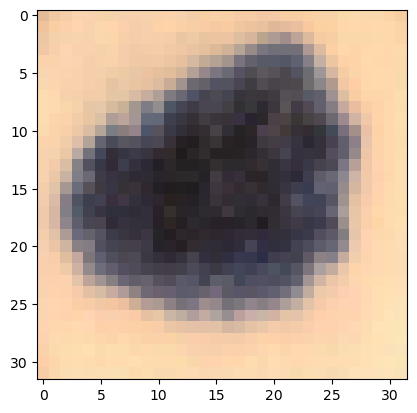

trainy


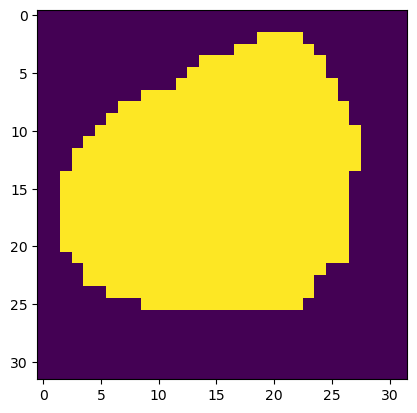

testx


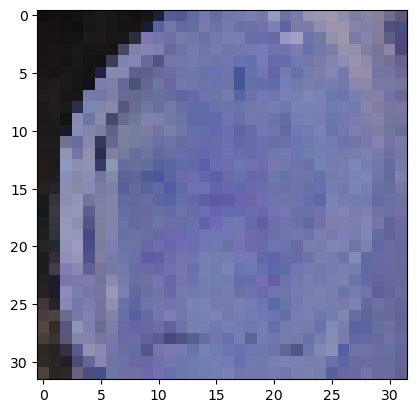

testy


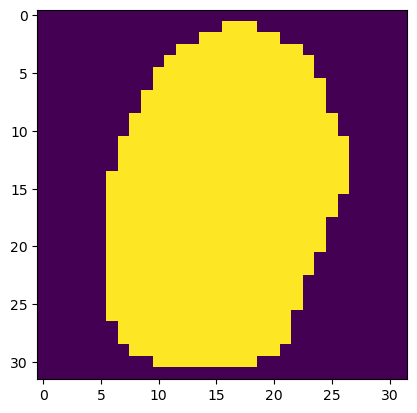

array([0, 1])

In [21]:
# Print image from each of these foldes
print('trainx')
plt.imshow(trainx[0])
plt.show()

print('trainy')
plt.imshow(trainy[0])
plt.show()

print('testx')
plt.imshow(testx[0])
plt.show()

print('testy')
plt.imshow(testy[0])
plt.show()

np.unique(trainy[0])

Defining the Model

In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1, 1, 3)),
    tf.keras.layers.Reshape((1, 3)),  
    # Replace Conv2D layers with LSTM layer (which was present in the first pixel-wise CNN segmentation model)
    tf.keras.layers.LSTM(64, activation='relu', return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation='sigmoid'))
])

model.compile(optimizer='adam',  loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 1, 3)              0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 64)             17408     
                                                                 
 time_distributed_1 (TimeDis  (None, 1, 1)             65        
 tributed)                                                       
                                                                 
Total params: 17,473
Trainable params: 17,473
Non-trainable params: 0
_________________________________________________________________


In [23]:
# Reshape entire trainx and trainy into array where each elem is 1x1x3
trainx_flat = trainx.reshape(-1, 1, 1, 3)
print('overall trainx shape : ', trainx_flat.shape)
print('shape of each image : ', trainx_flat[0].shape)

trainy_flat = trainy.reshape(-1, 1, 1, 1)

x_val_flat = x_val.reshape(-1, 1, 1, 3)
y_val_flat = y_val.reshape(-1, 1, 1, 1)

overall trainx shape :  (2048000, 1, 1, 3)
shape of each image :  (1, 1, 3)


In [24]:
!pip install focal-loss

In [25]:
# Metrics.

from focal_loss import BinaryFocalLoss

def accuracy(y_true, y_pred):
    '''Calculates the mean accuracy rate across all predictions for binary
    classification problems.
    '''
    return K.mean(K.equal(y_true, K.round(y_pred)))

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)


def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [27]:
hist = model.fit(trainx_flat, trainy_flat, validation_data=(x_val_flat, y_val_flat), epochs= 15, verbose=1)

Epoch 1/15
64000/64000 [==============================] - 457s 7ms/step - loss: 0.3276 - accuracy: 0.8717 - val_loss: 0.3268 - val_accuracy: 0.8743
Epoch 2/15
64000/64000 [==============================] - 671s 10ms/step - loss: 0.3213 - accuracy: 0.8738 - val_loss: 0.3235 - val_accuracy: 0.8737
Epoch 3/15
64000/64000 [==============================] - 1013s 16ms/step - loss: 0.3175 - accuracy: 0.8753 - val_loss: 0.3237 - val_accuracy: 0.8734
Epoch 4/15
64000/64000 [==============================] - 435s 7ms/step - loss: 0.3153 - accuracy: 0.8765 - val_loss: 0.3204 - val_accuracy: 0.8750
Epoch 5/15
64000/64000 [==============================] - 413s 6ms/step - loss: 0.3143 - accuracy: 0.8767 - val_loss: 0.3190 - val_accuracy: 0.8756
Epoch 6/15
64000/64000 [==============================] - 389s 6ms/step - loss: 0.3137 - accuracy: 0.8767 - val_loss: 0.3200 - val_accuracy: 0.8743
Epoch 7/15
64000/64000 [==============================] - 389s 6ms/step - loss: 0.3131 - accuracy: 0.8768 - v

{'loss': [0.3275705873966217, 0.3212551772594452, 0.317539244890213, 0.31529760360717773, 0.3143371045589447, 0.3136570155620575, 0.3130660951137543, 0.31231316924095154, 0.3117915689945221, 0.31141430139541626, 0.31109824776649475, 0.3108951449394226, 0.3107849061489105, 0.31066060066223145, 0.3105655908584595], 'accuracy': [0.8716601729393005, 0.8738363981246948, 0.8752675652503967, 0.8764614462852478, 0.876653790473938, 0.8767358660697937, 0.8767871260643005, 0.8768110275268555, 0.8770307898521423, 0.8770126700401306, 0.877182126045227, 0.8771703839302063, 0.8771874904632568, 0.8772538900375366, 0.8774467706680298], 'val_loss': [0.3267882764339447, 0.3235322833061218, 0.32370278239250183, 0.3203793168067932, 0.3190353214740753, 0.3200450539588928, 0.31764671206474304, 0.31636539101600647, 0.3173728883266449, 0.3162843585014343, 0.3166179060935974, 0.3149469494819641, 0.3167661726474762, 0.314643532037735, 0.31544211506843567], 'val_accuracy': [0.8742753863334656, 0.873708963394165, 

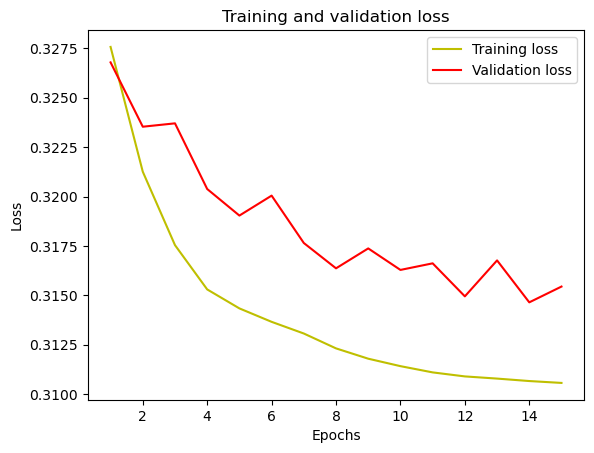

In [28]:
#plot the training and validation accuracy and loss at each epoch
history = hist
print(hist.history)
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

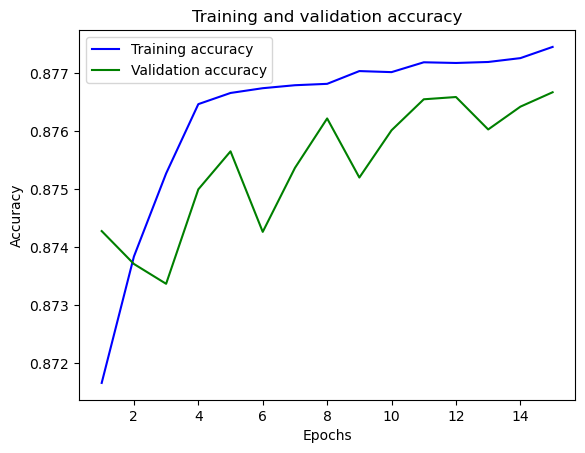

In [29]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot the training and validation accuracy at each epoch
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [30]:
testx_flat = np.array(testx).reshape(-1, 1, 1, 3)
testy_flat = np.array(testy).reshape(-1, 1, 1, 1)

loss, accuracy = model.evaluate(testx_flat, testy_flat)

print("Model Accuracy: {}".format(accuracy * 100))


19200/19200 [==============================] - 58s 3ms/step - loss: 0.3724 - accuracy: 0.8463
Model Accuracy: 84.63476300239563


In [31]:
# All training images
sum_iou=0
i = 0
for i in range(len(trainx)):
    test_img = trainx[i]
    ground_truth=trainy[i]

    prediction = model.predict(test_img.reshape(-1, 1, 1, 3))
    prediction = tf.where(prediction >= 0.3, 0, 1)

    IOU_keras = MeanIoU(num_classes=2)
    IOU_keras.update_state(ground_truth, prediction)
    sum_iou+=IOU_keras.result().numpy()*100
    print("IoU for the current prediction =", IOU_keras.result().numpy())
m_iou_simple = sum_iou/x_train.shape[0]
print("Mean IoU: ", m_iou_simple)

32/32 [==============================] - 1s 2ms/step
IoU for the current prediction = 0.13378906
32/32 [==============================] - 0s 2ms/step
IoU for the current prediction = 0.05810547
32/32 [==============================] - 0s 2ms/step
IoU for the current prediction = 0.020507812
32/32 [==============================] - 0s 2ms/step
IoU for the current prediction = 0.033203125
32/32 [==============================] - 0s 2ms/step
IoU for the current prediction = 0.037597656
32/32 [==============================] - 0s 2ms/step
IoU for the current prediction = 0.006359174
32/32 [==============================] - 0s 2ms/step
IoU for the current prediction = 0.039141025
32/32 [==============================] - 0s 2ms/step
IoU for the current prediction = 0.03125
32/32 [==============================] - 0s 2ms/step
IoU for the current prediction = 0.24427955
32/32 [==============================] - 0s 2ms/step
IoU for the current prediction = 0.020507812
32/32 [====================

In [34]:
len(trainx)

2000

In [36]:
# For all train images
pred_train_array = []
for i in range(len(trainx)):
    img = model.predict(trainx[i].reshape(-1, 1, 1, 3))
    pred_train_array.append(tf.where(img >= 0.3, 0, 1))

flat_truth_arr = trainy.flatten()

flat_preds_arr = np.array(pred_train_array).flatten()
cm = confusion_matrix(flat_truth_arr, flat_preds_arr, labels=list(range(2)))
ConfusionMatrixDisplay.from_predictions(flat_truth_arr, flat_preds_arr, normalize='true')

32/32 [==============================] - 0s 2ms/step


NameError: name 'confusion_matrix' is not defined

In [ ]:
# Calculating the True Positive Rate, False Positive Rate
def tpr_fpr_tnr_fnr(cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    tpr = tp/(tp+fn)
    fpr = fp/(fp+tn)
    tnr, fnr = 1-tpr, 1-fpr
    return tpr, fpr, tnr, fnr

In [ ]:
tpr, fpr, tnr, fnr = tpr_fpr_tnr_fnr(cm)
print("True Positive Rate(TPR): ",tpr)
print("False Positive Rate(FPR): ",fpr)
print("True Negative Rate(TNR): ", tnr)
print("False Negative Rate(FNR): ", fnr)

In [ ]:
print("F1 score of the predictions: ",f1_score(flat_truth_arr, flat_preds_arr, average='macro'))

In [ ]:
# All test images
sum_iou=0
i = 0
for i in range(len(testx)):
    test_img = testx[i]
    ground_truth=testy[i]

    prediction = model.predict(test_img.reshape(-1, 1, 1, 3))
    prediction = tf.where(prediction >= 0.3, 0, 1)

    IOU_keras = MeanIoU(num_classes=2)
    IOU_keras.update_state(ground_truth, prediction)
    sum_iou+=IOU_keras.result().numpy()*100
    print("IoU for the current prediction =", IOU_keras.result().numpy())
m_iou_simple = sum_iou/testx.shape[0]
print("Mean IoU: ", m_iou_simple)

In [ ]:
# For all test images
pred_test_array = []
for i in len(testx):
    img = model.predict(testx[i].reshape(-1, 1, 1, 3))
    pred_train_array.append(tf.where(img >= 0.3, 0, 1))

flat_truth_arr = testy.flatten()

flat_preds_arr = np.array(pred_test_array).flatten()
cm = confusion_matrix(flat_truth_arr, flat_preds_arr, labels=list(range(2)))
ConfusionMatrixDisplay.from_predictions(flat_truth_arr, flat_preds_arr, normalize='true')

In [ ]:
# Calculating the True Positive Rate, False Positive Rate
def tpr_fpr_tnr_fnr(cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    tpr = tp/(tp+fn)
    fpr = fp/(fp+tn)
    tnr, fnr = 1-tpr, 1-fpr
    return tpr, fpr, tnr, fnr

In [ ]:
tpr, fpr, tnr, fnr = tpr_fpr_tnr_fnr(cm)
print("True Positive Rate(TPR): ",tpr)
print("False Positive Rate(FPR): ",fpr)
print("True Negative Rate(TNR): ", tnr)
print("False Negative Rate(FNR): ", fnr)

In [ ]:
tf.keras.utils.plot_model(model, "model.png",show_shapes=True)

Visualization

In [ ]:
viz_test_image = testx_flat[:32 * 32]
predicted_output_image = model.predict(viz_test_image)

In [ ]:
predicted_output_image = predicted_output_image.reshape(32, 32, 1)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(np.array(testy_flat[:32*32]).reshape(32, 32, 1))
plt.title('Original Image Region')

# Predicted image
plt.subplot(1, 2, 2)
plt.imshow(predicted_output_image)
plt.title('Predicted Output Region')

plt.show()

In [ ]:
viz_test_image = testx_flat[:32 * 32]
predicted_output_image = model.predict(viz_test_image)

predicted_output_image = predicted_output_image.reshape(32, 32, 1)

condition = tf.reduce_all(predicted_output_image > 0.49, axis=-1)
predicted_output_image = tf.where(condition, 255, 0)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(np.array(testy_flat[:32*32]).reshape(32, 32, 1))
plt.title('Original Image Region')

# Predicted image
plt.subplot(1, 2, 2)
plt.imshow(predicted_output_image, cmap='gray')
plt.title('Predicted Output Region')

plt.show()

print(predicted_output_image)